In this note, I'll explore the Ipython `statsmodels` package for estimating linear regression models (OLS). The goal is to completely map stata commands for `reg` into something implementable in Ipython.

<!--TEASER_END-->

In [1]:
#load python libraries for this ipython notebook:
%matplotlib inline
import pandas as pd             # pandas data manipulation library
import statsmodels.formula.api as smf    # for the ols and robust ols model
import statsmodels.api as sm
import numpy as np

Note this is from the Tobias and Koop dataset on the returns to education.  The full dataset is a panel.  I have turned this into a cross section where `time==4` (for demonstration purposes only).

In [2]:
# load data and create dataframe
tobias_koop=pd.read_csv('http://rlhick.people.wm.edu/econ407/data/tobias_koop_t_4.csv')

With the pandas data frame created, we can easily run some models.  First let's look at the data, run summary statistics, and plot the histogram of our dependent variable, `ln_wage`.

In [3]:
tobias_koop.head()

id  educ  ln_wage  pexp  time  ability  meduc  feduc  broken_home  \
0   4    12     2.14     2     4     0.26     12     10            1   
1   6    15     1.91     4     4     0.44     12     16            0   
2   8    13     2.32     8     4     0.51     12     15            1   
3  11    14     1.64     1     4     1.82     16     17            1   
4  12    13     2.16     6     4    -1.30     13     12            0   

   siblings  pexp2  
0         4      4  
1         2     16  
2         2     64  
3         2      1  
4         5     36

In [4]:
tobias_koop.describe()

id         educ      ln_wage         pexp  time      ability  \
count  1034.000000  1034.000000  1034.000000  1034.000000  1034  1034.000000   
mean   1090.951644    12.274662     2.138259     4.815280     4     0.016596   
std     634.891728     1.566838     0.466280     2.190298     0     0.920963   
min       4.000000     9.000000     0.420000     0.000000     4    -3.140000   
25%     537.250000    12.000000     1.820000     3.000000     4    -0.550000   
50%    1081.500000    12.000000     2.120000     5.000000     4     0.170000   
75%    1666.500000    13.000000     2.450000     6.000000     4     0.720000   
max    2177.000000    19.000000     3.590000    12.000000     4     1.890000   

             meduc        feduc  broken_home     siblings        pexp2  
count  1034.000000  1034.000000  1034.000000  1034.000000  1034.000000  
mean     11.403288    11.585106     0.169246     3.200193    27.979691  
std       3.027277     3.735833     0.375150     2.126575    22.598790  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%      11.000000    10.000000     0.000000     2.000000     9.000000  
50%      12.000000    12.000000     0.000000     3.000000    25.000000  
75%      12.000000    14.000000     0.000000     4.000000    36.000000  
max      20.000000    20.000000     1.000000    15.000000   144.000000

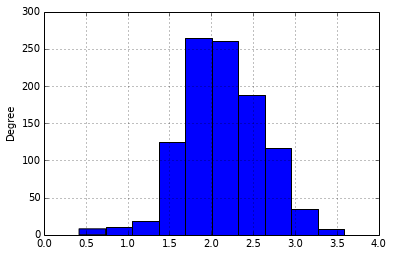

In [5]:
tobias_koop.ln_wage.plot(kind='hist')

# OLS analysis

This is the model we'll be estimating the vector \\(\beta\\) from

$$
y_i = \beta_0 + \beta_1 educ_i + \beta_2 pexp_i + \beta_3 pexp^2_i + \beta_4 broken\_home_i + \epsilon_i
$$

For now, we will ignore any potential bias due to endogeneity, although we'll come back to that in a later post.

## Fitting the model in stata

Here is the code for estimating the model in stata:

```
. reg ln_wage educ pexp pexp2 broken_home

      Source |       SS       df       MS              Number of obs =    1034
-------------+------------------------------           F(  4,  1029) =   51.36
       Model |  37.3778146     4  9.34445366           Prob > F      =  0.0000
    Residual |   187.21445  1029  .181938241           R-squared     =  0.1664
-------------+------------------------------           Adj R-squared =  0.1632
       Total |  224.592265  1033  .217417488           Root MSE      =  .42654

------------------------------------------------------------------------------
     ln_wage |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
        educ |   .0852725   .0092897     9.18   0.000     .0670437    .1035014
        pexp |   .2035214   .0235859     8.63   0.000     .1572395    .2498033
       pexp2 |  -.0124126   .0022825    -5.44   0.000    -.0168916   -.0079336
 broken_home |  -.0087254   .0357107    -0.24   0.807    -.0787995    .0613488
       _cons |   .4603326    .137294     3.35   0.001     .1909243    .7297408
------------------------------------------------------------------------------
```

## Fitting the model Ipython with statsmodels

We will estimate the same models as above using statsmodels.  

In [6]:
formula = "ln_wage ~ educ + pexp + pexp2 + broken_home"
results = smf.ols(formula,tobias_koop).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                ln_wage   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     51.36
Date:                Thu, 05 Mar 2015   Prob (F-statistic):           1.83e-39
Time:                        09:18:38   Log-Likelihood:                -583.66
No. Observations:                1034   AIC:                             1177.
Df Residuals:                    1029   BIC:                             1202.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept       0.4603      0.137      3.353      

# OLS Regression with robust standard errors

Recall that for robust standard errors, we first recover our OLS estimates ($\mathbf{b}$) of $\beta$.  Using $\mathbf{b}$, construct $\mathbf{e} = \mathbf{y - xb}$.  From there, calculate the robust variance/covariance matrix of estimated parameters as
$$
Var(\mathbf{b})_{robust} = \mathbf{(x'x)^{-1}x'diag(ee')x(x'x)^{-1}}\times \frac{N}{N-K}
$$
for calculating standard errors.

## Fitting the model in stata

In stata, we would run this:

```
. reg ln_wage educ pexp pexp2 broken_home, robust

Linear regression                                      Number of obs =    1034
                                                       F(  4,  1029) =   64.82
                                                       Prob > F      =  0.0000
                                                       R-squared     =  0.1664
                                                       Root MSE      =  .42654

------------------------------------------------------------------------------
             |               Robust
     ln_wage |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
        educ |   .0852725   .0099294     8.59   0.000     .0657882    .1047568
        pexp |   .2035214   .0226835     8.97   0.000     .1590101    .2480326
       pexp2 |  -.0124126   .0022447    -5.53   0.000    -.0168173   -.0080079
 broken_home |  -.0087254   .0312381    -0.28   0.780     -.070023    .0525723
       _cons |   .4603326   .1315416     3.50   0.000     .2022121     .718453
------------------------------------------------------------------------------
```

## Fitting the model in Ipython

In Ipython, we don't need to rerun the model.  The default OLS command already includes a number of different types of robust standard errors (one of which using the method outlined above).  All we need to do is create a new results instance that calls the covariance type we want:

In [7]:
results_robust = results.get_robustcov_results(cov_type='HC1')
print(results_robust.summary())

                            OLS Regression Results                            
Dep. Variable:                ln_wage   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     64.82
Date:                Thu, 05 Mar 2015   Prob (F-statistic):           6.41e-49
Time:                        09:18:39   Log-Likelihood:                -583.66
No. Observations:                1034   AIC:                             1177.
Df Residuals:                    1029   BIC:                             1202.
Df Model:                           4                                         
Covariance Type:                  HC1                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept       0.4603      0.132      3.500      

# Bootstrapped standard errors

## Fitting the model in stata


If instead, we want to bootstrap our standard errors, in stata we would do this:

```
. bstrap:  reg ln_wage educ pexp pexp2 broken_home
(running regress on estimation sample)

Bootstrap replications (50)
----+--- 1 ---+--- 2 ---+--- 3 ---+--- 4 ---+--- 5 
..................................................    50

Linear regression                               Number of obs      =      1034
                                                Replications       =        50
                                                Wald chi2(4)       =    290.46
                                                Prob > chi2        =    0.0000
                                                R-squared          =    0.1664
                                                Adj R-squared      =    0.1632
                                                Root MSE           =    0.4265

------------------------------------------------------------------------------
             |   Observed   Bootstrap                         Normal-based
     ln_wage |      Coef.   Std. Err.      z    P>|z|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
        educ |   .0852725    .010622     8.03   0.000     .0644539    .1060912
        pexp |   .2035214   .0217148     9.37   0.000     .1609611    .2460816
       pexp2 |  -.0124126   .0021076    -5.89   0.000    -.0165433   -.0082818
 broken_home |  -.0087254   .0330727    -0.26   0.792    -.0735466    .0560958
       _cons |   .4603326   .1405716     3.27   0.001     .1848173    .7358479
------------------------------------------------------------------------------

```


It is important to note that the above set of results implicitly assumes normality, since confidence intervals are symmetric about the mean (and since standard errors are reported).  

## Fitting the model in Ipython

This isn't as straightforward in Ipython.  We need to do a bit of wrangling to get the bootstrap working in Ipython.  Write our own routine.

In [9]:
R = 50

results_boot = np.zeros((R,results.params.shape[0]))

row_id = range(0,tobias_koop.shape[0])

for r in range(R):
     this_sample = np.random.choice(row_id, size=tobias_koop.shape[0], replace=True) # gives sampled row numbers
     # Define data for this replicate:    
     tobias_koop_r = tobias_koop.iloc[this_sample]   
     # Estimate model
     results_r = smf.ols(formula,tobias_koop_r).fit(disp=0).params   
     # Store in row r of results_boot:
     results_boot[r,:] = np.asarray(results_r)   

The array results_boot has all of our data.  Put in pandas dataframe and summarize:

In [10]:
# Convert results to pandas dataframe for easier analysis:
results_boot = pd.DataFrame(results_boot,columns=['b_Intercept','b_educ','b_pexp','pexp2','b_broken_home'])
results_boot.describe(percentiles=[.025,.975])

b_Intercept     b_educ     b_pexp      pexp2  b_broken_home
count    50.000000  50.000000  50.000000  50.000000      50.000000
mean      0.462494   0.084486   0.208471  -0.012965      -0.017659
std       0.160763   0.011046   0.024721   0.002473       0.036356
min       0.004603   0.056518   0.148656  -0.019397      -0.102527
2.5%      0.126781   0.064798   0.157471  -0.018137      -0.100246
50%       0.462583   0.084843   0.209224  -0.013365      -0.010556
97.5%     0.783207   0.105074   0.260848  -0.008159       0.054402
max       0.801684   0.118317   0.273543  -0.007170       0.066333

In the above set of results, the standard deviation (`std`) can be interpreted as the parameter standard error if we are willing to impose normality.  Alternatively, we could construct 95% confidence intervals by looking at the 2.5% and 97.5% percentiles.